In [138]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score



## Load and Understand the data

In [139]:
df = pd.read_excel(r"C:\Users\91799\Downloads\clv dataset.xlsx")
df

,InvoiceNo,CustomerID,InvoiceDate,Amount,Category,Country
0,INV100000,CUST0103,2023-02-21,65.58,Beauty,USA
1,INV100001,CUST0180,2024-01-10,102.81,Home & Kitchen,India
2,INV100002,CUST0093,2024-12-08,6.71,Clothing,India
3,INV100003,CUST0015,2023-02-04,86.75,Books,Canada
4,INV100004,CUST0107,2024-09-03,82.44,Clothing,USA
...,...,...,...,...,...,...
2993,INV102995,CUST0173,2023-08-07,90.99,Home & Kitchen,India
2994,INV102996,CUST0020,2023-08-07,212.78,Beauty,India
2995,INV102997,CUST0017,2024-09-30,5.09,Clothing,Canada
2996,INV102998,CUST0119,2024-04-17,29.71,Clothing,Germany


In [140]:
df.head()

,InvoiceNo,CustomerID,InvoiceDate,Amount,Category,Country
0,INV100000,CUST0103,2023-02-21,65.58,Beauty,USA
1,INV100001,CUST0180,2024-01-10,102.81,Home & Kitchen,India
2,INV100002,CUST0093,2024-12-08,6.71,Clothing,India
3,INV100003,CUST0015,2023-02-04,86.75,Books,Canada
4,INV100004,CUST0107,2024-09-03,82.44,Clothing,USA


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    2998 non-null   object        
 1   CustomerID   2998 non-null   object        
 2   InvoiceDate  2998 non-null   datetime64[ns]
 3   Amount       2998 non-null   float64       
 4   Category     2998 non-null   object        
 5   Country      2998 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 140.7+ KB


## Data preprocessing

In [143]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%Y-%m-%d")

In [144]:
df.dropna(subset=['InvoiceNo','CustomerID', 'InvoiceDate', 'Amount','Category','Country'], inplace=True)
df = df[df['Amount'] > 0]

In [145]:
df

,InvoiceNo,CustomerID,InvoiceDate,Amount,Category,Country
0,INV100000,CUST0103,2023-02-21,65.58,Beauty,USA
1,INV100001,CUST0180,2024-01-10,102.81,Home & Kitchen,India
2,INV100002,CUST0093,2024-12-08,6.71,Clothing,India
3,INV100003,CUST0015,2023-02-04,86.75,Books,Canada
4,INV100004,CUST0107,2024-09-03,82.44,Clothing,USA
...,...,...,...,...,...,...
2993,INV102995,CUST0173,2023-08-07,90.99,Home & Kitchen,India
2994,INV102996,CUST0020,2023-08-07,212.78,Beauty,India
2995,INV102997,CUST0017,2024-09-30,5.09,Clothing,Canada
2996,INV102998,CUST0119,2024-04-17,29.71,Clothing,Germany


In [146]:
print(df['InvoiceDate'].dtype)

datetime64[ns]


## RFM Feature Engineering

In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': [
        lambda x: (snapshot_date - x.max()).days,  # Recency
        lambda x: (x.max() - x.min()).days + 1     # Tenure
    ],
    'InvoiceNo': 'nunique',                      # Frequency
    'Amount': ['sum', 'mean']                   # Monetary
})

In [148]:
#Rename the columns
rfm.columns = ['Recency', 'Tenure', 'Frequency', 'Monetary', 'AvgOrderValue']
rfm = rfm.reset_index()

## CLV Calculation

In [149]:
rfm['CLV'] = rfm['Frequency'] * rfm['AvgOrderValue'] * (rfm['Tenure'] / 30)


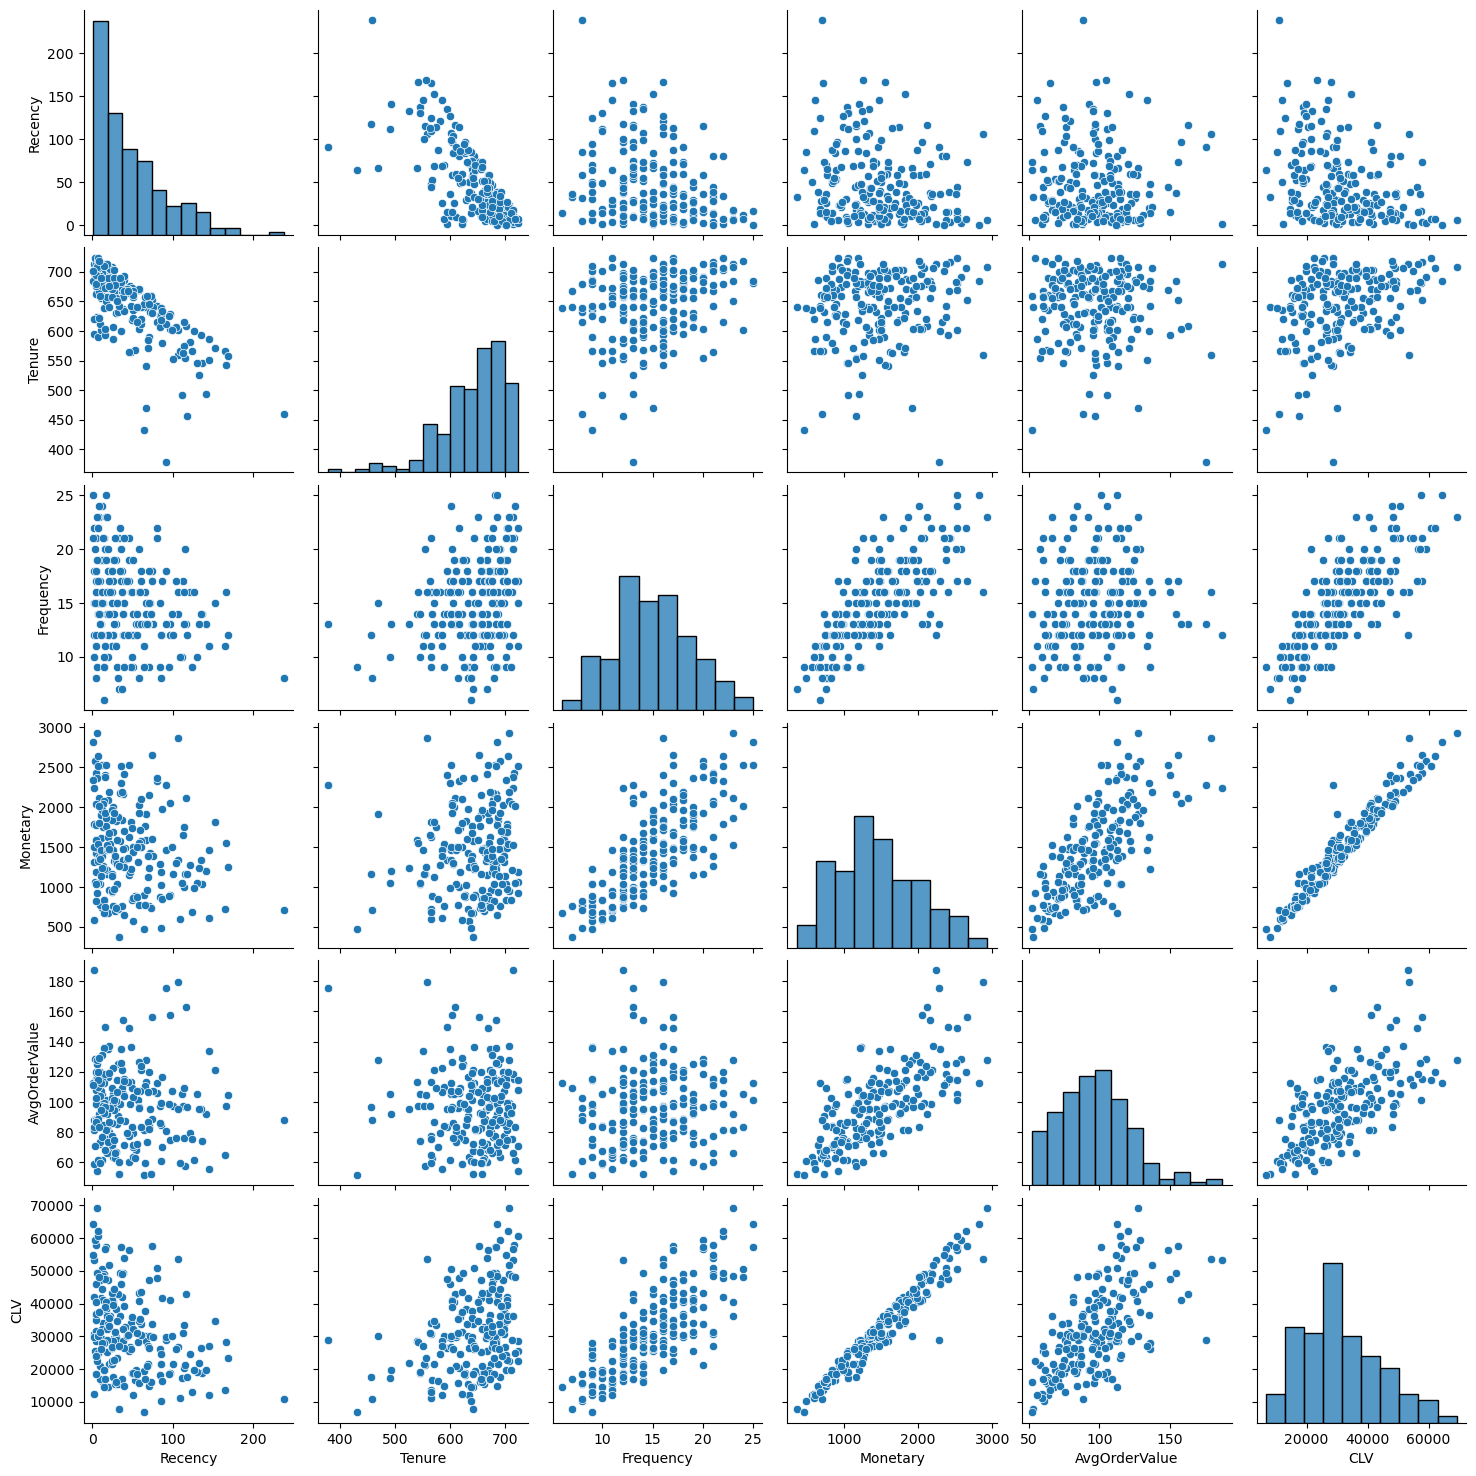

In [150]:
# Seperate Independent and Dependent variables
X = rfm[['Recency', 'Tenure', 'Frequency', 'Monetary', 'AvgOrderValue']]
y = rfm['CLV'] 
sns.pairplot( data = rfm )
plt.show()

## Train-Test Split

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Linear Regression Model

In [152]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

#Accuracy
lr.score(X_test,y_test)*100

98.32876529039474

## Random Forest Model

In [153]:
rf = RandomForestRegressor(n_estimators=200,max_depth=50,min_samples_split=2,random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#Accuracy
rf.score(X_test,y_test)*100

91.0871450264727

## XGBoost Model

In [132]:
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

#Accuracy
xgb.score(X_test,y_test)*100


93.12783185788815

## Evaluate Models

In [160]:
def evaluate(y_true, y_pred, model_name):
    print(f"{model_name} Evaluation:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:",root_mean_squared_error(y_true, y_pred))
    print("R² Score:", r2_score(y_true, y_pred))
    print()

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")
evaluate(y_test, y_pred_xgb, "XGBRegressor")

Linear Regression Evaluation:
MAE: 814.1104430248266
RMSE: 1372.4432819717385
R² Score: 0.9832876529039475

Random Forest Evaluation:
MAE: 1409.6168488749963
RMSE: 3169.4514400637963
R² Score: 0.9108714502647269

XGBRegressor Evaluation:
MAE: 1298.842390299479
RMSE: 2783.0600084790603
R² Score: 0.9312783185788815



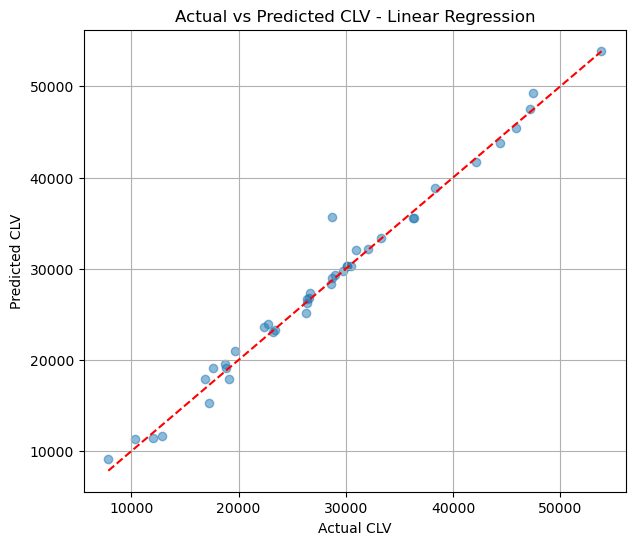

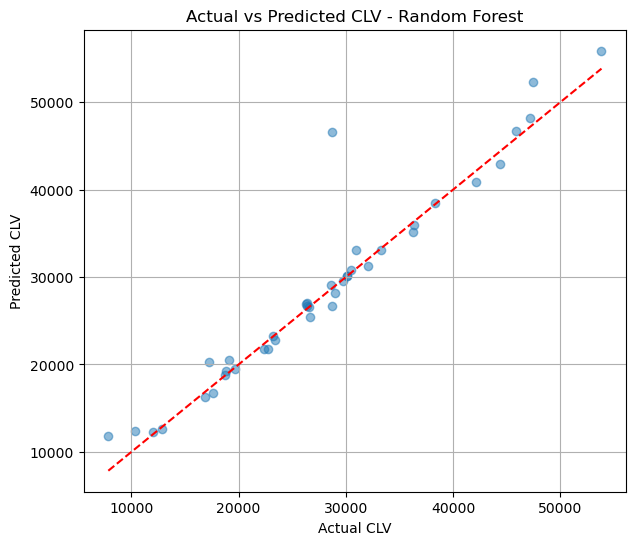

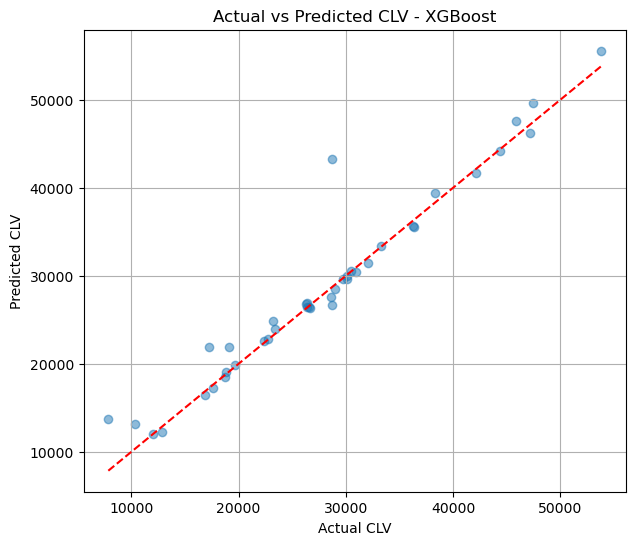

In [161]:
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(7, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel("Actual CLV")
    plt.ylabel("Predicted CLV")
    plt.title(f"Actual vs Predicted CLV - {model_name}")
    plt.grid(True)
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_lr, "Linear Regression")
plot_actual_vs_predicted(y_test, y_pred_rf, "Random Forest")
plot_actual_vs_predicted(y_test, y_pred_xgb, "XGBoost")

## Conclusion
Multiple Linear Regression gave the lowest RMSE and highest R2 score, this shows it performed best on this dataset.We can clearly see the best fit line using linear Regression model as It is giving accurate predictions .